In [2]:
import pandas as pd

# Replace 'your_file_name.csv' with your actual file name or path
df = pd.read_csv("cleaned_movies.csv")


In [3]:
df.head()

,movieId,title,userId,rating,timestamp,Musical,Western,Thriller,Sci-Fi,Adventure,...,Mystery,Fantasy,Drama,Documentary,Animation,Comedy,Romance,Horror,Unknown,rating_year
0,1,Toy Story (1995),10.0,2.5,2007-01-20 03:53:51,0,0,0,0,1,...,0,1,0,0,1,1,0,0,0,2007
1,1,Toy Story (1995),11.0,3.0,1996-12-08 22:44:36,0,0,0,0,1,...,0,1,0,0,1,1,0,0,0,1996
2,1,Toy Story (1995),17.0,4.0,2002-07-22 02:42:31,0,0,0,0,1,...,0,1,0,0,1,1,0,0,0,2002
3,1,Toy Story (1995),19.0,3.0,2000-11-20 07:14:48,0,0,0,0,1,...,0,1,0,0,1,1,0,0,0,2000
4,1,Toy Story (1995),20.0,5.0,2019-03-21 16:03:50,0,0,0,0,1,...,0,1,0,0,1,1,0,0,0,2019


In [5]:
# ------------------------
# SVD pipeline (uses cleaned `df`)
# ------------------------
import pandas as pd
import numpy as np
import heapq
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# ----- Assumptions -----
# `df` is your cleaned DataFrame already present in the notebook.
# It must contain columns: 'userId', 'movieId', 'rating'
# Optional: 'title' (if present we'll use it; otherwise we'll try to load movies.csv)

# Basic checks & types
assert {'userId','movieId','rating'}.issubset(set(df.columns)), "df must contain userId, movieId, rating"
df['userId'] = df['userId'].astype(int)
df['movieId'] = df['movieId'].astype(int)
df['rating'] = df['rating'].astype(float)

# If title not in df, try to load movies.csv (adjust path if needed)
if 'title' not in df.columns:
    try:
        movies = pd.read_csv("movies.csv")
    except Exception:
        movies = None
else:
    movies = df[['movieId','title']].drop_duplicates()

# Build a movie title map for fast lookup
if movies is not None:
    movie_title_map = movies.set_index('movieId')['title'].to_dict()
else:
    movie_title_map = {}

# ------------------------
# 1) Prepare Surprise Dataset
# ------------------------
min_rating = df['rating'].min()
max_rating = df['rating'].max()
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

# ------------------------
# 2) Cross-validate SVD
# ------------------------
print("Running 1-fold cross-validation with SVD...")
svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.04, random_state=42)
cv_results = cross_validate(svd_model, data, measures=['RMSE','MAE'], cv=1, verbose=True, n_jobs=-1)

cv_df = pd.DataFrame(cv_results)
print("\nCross-Validation summary:")
print(cv_df[['test_rmse','test_mae']])
print(f"\nAverage RMSE: {cv_df['test_rmse'].mean():.4f}")
print(f"Average MAE: {cv_df['test_mae'].mean():.4f}")

# ------------------------
# 3) Train final model on full data
# ------------------------
print("\nTraining final SVD on full dataset...")
trainset = data.build_full_trainset()
svd_model.fit(trainset)
print("Training complete.")

# ------------------------
# 4) Fast Top-N recommender helper (Surprise predict loop + heapq)
# ------------------------
# Build a user -> set(rated_movieIds) mapping from df
user_rated_map = df.groupby('userId')['movieId'].apply(set).to_dict()
all_movie_ids = df['movieId'].unique()  # candidate pool (movies present in df)

# Popularity fallback in case of new/cold users
popularity = df['movieId'].value_counts()
popular_movie_ids = popularity.index.tolist()

def get_top_n_recommendations_fast(user_id, model, n=10, candidate_movie_ids=None, fallback_top=10):
    """
    Returns list of tuples: (movieId, title_if_known, predicted_rating)
    - model: trained Surprise algo (fitted on full trainset)
    - candidate_movie_ids: iterable of movieIds to consider (defaults to all movies in df)
    - fallback_top: number of popular movies to return for cold-start user
    """
    if candidate_movie_ids is None:
        candidate_movie_ids = all_movie_ids

    rated = user_rated_map.get(user_id, set())

    # Cold-start user: return top-popular (not yet rated) as fallback
    if user_id not in user_rated_map:
        recs = []
        for mid in popular_movie_ids:
            if mid in rated:
                continue
            recs.append((int(mid), movie_title_map.get(int(mid), "Unknown Title"), None))
            if len(recs) >= n:
                break
        return recs

    # maintain a min-heap of size n
    heap = []
    push = heapq.heappush
    pop = heapq.heappop

    for mid in candidate_movie_ids:
        if mid in rated:
            continue
        # predict (Surprise handles unknown ids by returning global mean or appropriate estimate)
        est = model.predict(uid=user_id, iid=mid).est
        if len(heap) < n:
            push(heap, (est, int(mid)))
        else:
            if est > heap[0][0]:
                pop(heap)
                push(heap, (est, int(mid)))

    # Convert heap to sorted list (descending)
    topn = sorted(heap, key=lambda x: -x[0])
    return [(mid, movie_title_map.get(mid, "Unknown Title"), round(score, 3)) for score, mid in topn]


# Example: show top-10 for an example user (choose a user that exists in df)
example_user = int(df['userId'].iloc[0])
print(f"\nTop recommendations for user {example_user}:")
top_recs = get_top_n_recommendations_fast(example_user, svd_model, n=10)
for i, (mid, title, score) in enumerate(top_recs, 1):
    print(f"{i}. {title} (movieId={mid})  est={score}")

# ------------------------
# 5) (Optional) Top-K evaluation: Precision@K, Recall@K, NDCG@K
# ------------------------
def precision_at_k(predicted_ids, relevant_set, k):
    if len(predicted_ids) == 0:
        return 0.0
    pred_k = predicted_ids[:k]
    return len([p for p in pred_k if p in relevant_set]) / k

def recall_at_k(predicted_ids, relevant_set, k):
    if len(relevant_set) == 0:
        return 0.0
    pred_k = predicted_ids[:k]
    return len([p for p in pred_k if p in relevant_set]) / len(relevant_set)

def ndcg_at_k(predicted_ids, relevant_set, k):
    if len(relevant_set) == 0:
        return 0.0
    dcg = 0.0
    for i, p in enumerate(predicted_ids[:k], start=1):
        if p in relevant_set:
            dcg += 1.0 / np.log2(i + 1.0)
    ideal = sum(1.0 / np.log2(i + 1.0) for i in range(1, min(len(relevant_set), k) + 1))
    return dcg / ideal if ideal > 0 else 0.0

# If you want to run Top-K evaluation, uncomment and run the following block:
"""
# Build a train/test split (random) for evaluation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Rebuild user_rated_map and popularity for the train split
train_user_rated = train_df.groupby('userId')['movieId'].apply(set).to_dict()
test_user_relevant = test_df[test_df['rating'] >= 4.0].groupby('userId')['movieId'].apply(set).to_dict()
candidate_movies_train = train_df['movieId'].unique()

users_to_eval = [u for u in test_user_relevant.keys() if u in train_user_rated]
print("Users to evaluate:", len(users_to_eval))

K = 10
precisions, recalls, ndcgs = [], [], []
for u in users_to_eval:
    recs = get_top_n_recommendations_fast(u, svd_model, n=K, candidate_movie_ids=candidate_movies_train)
    rec_ids = [r[0] for r in recs]
    relevant = test_user_relevant.get(u, set())
    precisions.append(precision_at_k(rec_ids, relevant, K))
    recalls.append(recall_at_k(rec_ids, relevant, K))
    ndcgs.append(ndcg_at_k(rec_ids, relevant, K))

print(f"Precision@{K}: {np.mean(precisions):.4f}")
print(f"Recall@{K}: {np.mean(recalls):.4f}")
print(f"NDCG@{K}: {np.mean(ndcgs):.4f}")
"""


Running 1-fold cross-validation with SVD...


ValueError: Incorrect value for n_splits=32000204. Must be >=2 and less than the number of ratings

In [6]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import pandas as pd
import numpy as np

# -----------------------
# 1️⃣  Prepare Data
# -----------------------
# Assumes your cleaned DataFrame is already loaded as `df`
# Columns required: userId, movieId, rating
df['userId'] = df['userId'].astype(int)
df['movieId'] = df['movieId'].astype(int)
df['rating'] = df['rating'].astype(float)

# Define rating scale dynamically from your data
min_rating = df['rating'].min()
max_rating = df['rating'].max()
reader = Reader(rating_scale=(min_rating, max_rating))

# Load Surprise dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# -----------------------
# 2️⃣  Split into Train/Test
# -----------------------
# Keep 20% for testing
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# -----------------------
# 3️⃣  Define and Train Model
# -----------------------
# Tip: start small for quick tests, increase later (n_factors=100, n_epochs=20)
svd_model = SVD(
    n_factors=50,        # latent factors
    n_epochs=10,         # SGD iterations
    lr_all=0.005,        # learning rate
    reg_all=0.04,        # regularization
    random_state=42
)

print("Training SVD model...")
svd_model.fit(trainset)
print("Training complete!")

# -----------------------
# 4️⃣  Evaluate Model
# -----------------------
print("Evaluating on test data...")
predictions = svd_model.test(testset)

rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)

print(f"\n✅ Quick Split Evaluation Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# -----------------------
# 5️⃣  Optional: Example recommendation
# -----------------------
# If you want a top-N list for a given user (e.g., userId=1)
example_user_id = int(df['userId'].iloc[0])
all_movie_ids = df['movieId'].unique()

# Movies already rated by this user
rated_movies = df[df['userId'] == example_user_id]['movieId'].unique()
unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]

# Predict for a few unrated movies (for demo)
sample_unrated = np.random.choice(unrated_movies, 10, replace=False)
preds = [(mid, svd_model.predict(example_user_id, mid).est) for mid in sample_unrated]

print(f"\nExample recommendations for user {example_user_id}:")
for mid, est in sorted(preds, key=lambda x: -x[1]):
    print(f"MovieID {mid}: predicted rating = {est:.2f}")

Training SVD model...
Training complete!
Evaluating on test data...
RMSE: 0.8259
MAE:  0.6243

✅ Quick Split Evaluation Results:
RMSE: 0.8259
MAE : 0.6243

Example recommendations for user 10:
MovieID 89592: predicted rating = 3.14
MovieID 101685: predicted rating = 3.14
MovieID 199269: predicted rating = 3.08
MovieID 215527: predicted rating = 2.98
MovieID 134979: predicted rating = 2.94
MovieID 113457: predicted rating = 2.88
MovieID 169858: predicted rating = 2.86
MovieID 184317: predicted rating = 2.84
MovieID 288595: predicted rating = 2.81
MovieID 144212: predicted rating = 2.63


In [7]:
from surprise.model_selection import GridSearchCV
from surprise import SVD, Dataset, Reader

# sample df
df_small = df.sample(frac=0.05, random_state=42)
reader = Reader(rating_scale=(df_small.rating.min(), df_small.rating.max()))
data_small = Dataset.load_from_df(df_small[['userId','movieId','rating']], reader)

param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=1, joblib_verbose=0)
gs.fit(data_small)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


0.8993506795142531
{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}


In [8]:
from collections import defaultdict
from surprise import accuracy

# --- 1️⃣ Evaluate RMSE & MAE first (for consistency)
predictions = svd_model.test(testset)
print("RMSE:", accuracy.rmse(predictions))
print("MAE :", accuracy.mae(predictions))

# --- 2️⃣ Define precision and recall metrics
def get_top_n(predictions, n=10, min_rating=3.5):
    """
    Return top-N predictions for each user.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if est >= min_rating:
            top_n[uid].append((iid, est))

    # sort each user's predictions and keep top-N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """
    Compute Precision@K and Recall@K for each user.
    """
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        # sort by estimated rating
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # top-K items
        top_k = user_ratings[:k]

        # count relevant items (true_r >= threshold)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((true_r >= threshold) for (_, true_r) in top_k)

        precisions[uid] = n_rec_k / k if k else 0
        recalls[uid] = n_rec_k / n_rel if n_rel else 0

    return precisions, recalls


# --- 3️⃣ Compute Precision@10 and Recall@10
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)

# --- 4️⃣ Print aggregate results
mean_precision = sum(prec for prec in precisions.values()) / len(precisions)
mean_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f"✅ Precision@10: {mean_precision:.4f}")
print(f"✅ Recall@10   : {mean_recall:.4f}")


RMSE: 0.8259
RMSE: 0.8259348026326113
MAE:  0.6243
MAE : 0.624267402172257
✅ Precision@10: 0.6625
✅ Recall@10   : 0.6679


Sample rows: 316,137  (mode=by_users, frac=0.01)
Unique users in sample: 2009  Unique movies: 19437
Trainset approx size: 252909  Testset size: 63228

Training: n_epochs=5 ...
n_epochs=5  RMSE=0.8872  time=14.7s

Training: n_epochs=10 ...
n_epochs=10  RMSE=0.8760  time=1.0s

Training: n_epochs=20 ...
n_epochs=20  RMSE=0.8600  time=1.7s

Training: n_epochs=30 ...
n_epochs=30  RMSE=0.8509  time=2.5s

Training: n_epochs=40 ...
n_epochs=40  RMSE=0.8490  time=3.3s

Summary:
   n_epochs      rmse     time_s
0         5  0.887212  14.704892
1        10  0.876003   1.028223
2        20  0.860041   1.738115
3        30  0.850873   2.525794
4        40  0.849008   3.281318


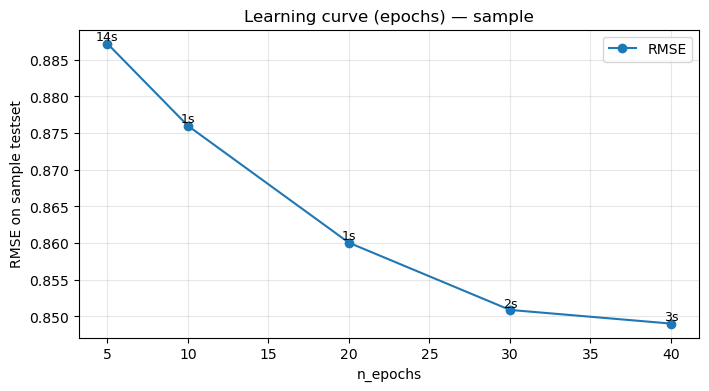

In [17]:
# -------------------------------
# Epoch diagram on 1% user-sample
# -------------------------------
import time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# --- USER SETTINGS (tweak) ---
SAMPLE_MODE = "by_users"   # "by_users" preferred, or "by_rows"
SAMPLE_FRAC = 0.01         # 1% sample
RANDOM_STATE = 42

# Use the same modeling hyperparams as your full model for comparability:
n_factors = 100
lr_all = 0.005
reg_all = 0.04

# Epochs to try (small list finishes faster)
epochs_to_try = [5, 10, 20, 30, 40]  
test_size = 0.2
# -------------------------------

# 1) Build reproducible sample
if SAMPLE_MODE == "by_users":
    user_ids = df['userId'].unique()
    n_sample_users = max(1, int(len(user_ids) * SAMPLE_FRAC))
    random.seed(RANDOM_STATE)
    sampled_users = set(random.sample(list(user_ids), n_sample_users))
    df_sample = df[df['userId'].isin(sampled_users)].reset_index(drop=True)
else:
    df_sample = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"Sample rows: {len(df_sample):,}  (mode={SAMPLE_MODE}, frac={SAMPLE_FRAC})")
print("Unique users in sample:", df_sample['userId'].nunique(), " Unique movies:", df_sample['movieId'].nunique())

# 2) Prepare Surprise dataset and split once
reader = Reader(rating_scale=(df_sample['rating'].min(), df_sample['rating'].max()))
data_sample = Dataset.load_from_df(df_sample[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data_sample, test_size=test_size, random_state=RANDOM_STATE)
print("Trainset approx size:", len(list(trainset.all_ratings())), " Testset size:", len(testset))


# 3) Loop over epochs: retrain fresh model each time, measure RMSE and time
results = []
for epochs in epochs_to_try:
    print(f"\nTraining: n_epochs={epochs} ...")
    t0 = time.time()
    algo = SVD(n_factors=n_factors, n_epochs=epochs, lr_all=lr_all, reg_all=reg_all, random_state=RANDOM_STATE)
    algo.fit(trainset)                 # trains from scratch for this epochs value
    preds = algo.test(testset)
    rmse = accuracy.rmse(preds, verbose=False)
    elapsed = time.time() - t0
    print(f"n_epochs={epochs}  RMSE={rmse:.4f}  time={elapsed:.1f}s")
    results.append({'n_epochs': epochs, 'rmse': rmse, 'time_s': elapsed})

# 4) Results table + plot
res_df = pd.DataFrame(results)
print("\nSummary:")
print(res_df)

plt.figure(figsize=(8,4))
plt.plot(res_df['n_epochs'], res_df['rmse'], marker='o', label='RMSE')
for i,row in res_df.iterrows():
    plt.text(row['n_epochs'], row['rmse'], f"{int(row['time_s'])}s", ha='center', va='bottom', fontsize=9)
plt.xlabel("n_epochs")
plt.ylabel("RMSE on sample testset")
plt.title("Learning curve (epochs) — sample")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [13]:
import random
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# --------------------------------------------------
# 1️⃣  Sample ~1% of your full dataset
# --------------------------------------------------
df_sample = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
print(f"Sample size: {len(df_sample):,} rows out of {len(df):,}")

reader = Reader(rating_scale=(df_sample['rating'].min(), df_sample['rating'].max()))
data_sample = Dataset.load_from_df(df_sample[['userId', 'movieId', 'rating']], reader)

# --------------------------------------------------
# 2️⃣  Define Randomized Search
# --------------------------------------------------
def random_search(data, n_trials=10, cv=2, random_state=42):
    random.seed(random_state)
    best = (1e9, None)

    # Slightly reduced parameter space (faster)
    param_space = {
        'n_factors': [50, 75, 100],
        'n_epochs': [10, 15, 20],
        'lr_all': [0.002, 0.005, 0.01],
        'reg_all': [0.01, 0.02, 0.04]
    }

    keys = list(param_space.keys())

    for t in range(n_trials):
        params = {k: random.choice(param_space[k]) for k in keys}
        algo = SVD(**params, random_state=random_state)

        res = cross_validate(
            algo, data, measures=['rmse'], cv=cv, verbose=False, n_jobs=1
        )
        mean_rmse = np.mean(res['test_rmse'])
        print(f"Trial {t+1}/{n_trials}: RMSE={mean_rmse:.4f}, Params={params}")

        if mean_rmse < best[0]:
            best = (mean_rmse, params)

    return best

# --------------------------------------------------
# 3️⃣  Run Randomized Search
# --------------------------------------------------
best_rmse, best_params = random_search(data_sample, n_trials=10)
print("\n✅ Random Search Complete")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best Params: {best_params}")


Sample size: 3,200,020 rows out of 32,000,204
Trial 1/10: RMSE=0.9188, Params={'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.04}
Trial 2/10: RMSE=0.9191, Params={'n_factors': 75, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.01}
Trial 3/10: RMSE=0.8955, Params={'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.04}
Trial 4/10: RMSE=0.9055, Params={'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02}
Trial 5/10: RMSE=0.9177, Params={'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.01}
Trial 6/10: RMSE=0.9529, Params={'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.01}
Trial 7/10: RMSE=0.8956, Params={'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.04}
Trial 8/10: RMSE=0.9197, Params={'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.01}
Trial 9/10: RMSE=0.9153, Params={'n_factors': 75, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.01}
Trial 10/10: RMSE=0.8980, Params={'n_factors': 50, 'n